I'd like to try XGBoost for predictions.  Will it work better than the simple neural network model I made in notebook #10?  By that I mean:

- will it be more accurate?
- will it work for all continents, rather than just one?

I'm taking a lot of help from ["Avoid overfitting by early stopping with xgboost in Python"](https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/) from Machine Learning Mastery.

Standard imports follow.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook

# set seed for reproducibility
seed = 42
np.random.seed(seed)

Now let's load our data.

In [2]:
from src.data.load_dataset import load_dataset, load_and_count_by_band

import src.data.utils as utils

data_file = '../data/interim/ve7cc_dx.csv'
data_20m = load_and_count_by_band(data_file, 
                                  start_date='2018-01-01',
                                  end_date='2019-06-30')
validation_data = load_and_count_by_band(data_file,
                                         start_date='2019-07-01',
                                         end_date='2019-12-29')
utils.add_solar_elevation(data_20m, city_name='Vancouver')
utils.add_solar_elevation(validation_data, city_name='Vancouver')
features_cnt = len(data_20m.columns) - 1

In [3]:
data_20m.head()

total  sunspots_count  hour  month    annual  weekend  \
date                                                                         
2018-01-01 00:00:00     17               0     0      1  0.002732      0.0   
2018-01-01 01:00:00     13               0     1      1  0.002732      0.0   
2018-01-01 02:00:00      1               0     2      1  0.002732      0.0   
2018-01-01 03:00:00      0               0     3      1  0.002732      0.0   
2018-01-01 04:00:00      0               0     4      1  0.002732      0.0   

                     arrl_dx_contest  solar_elevation  
date                                                   
2018-01-01 00:00:00              0.0         2.509857  
2018-01-01 01:00:00              0.0        -5.748409  
2018-01-01 02:00:00              0.0       -14.733074  
2018-01-01 03:00:00              0.0       -24.258526  
2018-01-01 04:00:00              0.0       -34.020552

Let's try making an XGBoost regressor model.  I'm following the approach outlined [here](https://www.datacamp.com/community/tutorials/xgboost-in-python).

In [4]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

X, y = data_20m.iloc[:,1:], data_20m.iloc[:,0]
data_dmatrix = xgb.DMatrix(data=X,label=y)

/home/aardvark/dev/loostmap/venv/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/aardvark/dev/loostmap/venv/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Let's use the sklearn `TimeSeriesSplit` to do kfold validation.

In [5]:
from sklearn.model_selection import TimeSeriesSplit

kf_ts = TimeSeriesSplit(n_splits=5)

xg_reg_cv = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, 
                             learning_rate = 0.1, max_depth = 5, alpha = 10, 
                             n_estimators = 50, num_boost_round=200)

In [6]:
for train_index, test_index in kf_ts.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)
    xg_reg_cv.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_test, y_test)],
                  eval_metric='rmse')

[14:06:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:21.869	validation_1-rmse:37.7404
[1]	validation_0-rmse:21.2749	validation_1-rmse:37.5107
[2]	validation_0-rmse:21.0042	validation_1-rmse:37.4352
[3]	validation_0-rmse:20.7809	validation_1-rmse:37.3786
[4]	validation_0-rmse:20.4125	validation_1-rmse:37.3329
[5]	validation_0-rmse:19.9986	validation_1-rmse:37.1787
[6]	validation_0-rmse:18.5937	validation_1-rmse:37.1086
[7]	validation_0-rmse:17.3173	validation_1-rmse:37.0701
[8]	validation_0-rmse:17.0141	validation_1-rmse:36.9714
[9]	validation_0-rmse:16.8956	validation_1-rmse:36.9272
[10]	validation_0-rmse:16.6665	validation_1-rmse:36.899
[11]	validation_0-rmse:16.2422	validation_1-rmse:36.8435
[12]	validation_0-rmse:16.1169	validation_1-rmse:36.818
[13]	validation_0-rmse:16.0146	validation_1-rmse:36.795
[14]	validation_0-rmse:15.8935	validation_1-rmse:36.6793
[15]	validation_0-rmse:15.6167	v

[39]	validation_0-rmse:14.5528	validation_1-rmse:15.0135
[40]	validation_0-rmse:14.4794	validation_1-rmse:15.0161
[41]	validation_0-rmse:14.4527	validation_1-rmse:15.0192
[42]	validation_0-rmse:14.4238	validation_1-rmse:15.0215
[43]	validation_0-rmse:14.3755	validation_1-rmse:15.0373
[44]	validation_0-rmse:14.3359	validation_1-rmse:15.0456
[45]	validation_0-rmse:14.1735	validation_1-rmse:15.0432
[46]	validation_0-rmse:14.1473	validation_1-rmse:15.0465
[47]	validation_0-rmse:14.0889	validation_1-rmse:15.0482
[48]	validation_0-rmse:13.9883	validation_1-rmse:15.0678
[49]	validation_0-rmse:13.9701	validation_1-rmse:15.0703
[14:06:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:23.538	validation_1-rmse:17.6136
[1]	validation_0-rmse:23.1024	validation_1-rmse:17.3567
[2]	validation_0-rmse:22.6551	validation_1-rmse:17.2255
[3]	validation_0-rmse:22.2124	validation_1-rmse:17.1467
[4]	validation_0-rmse:2

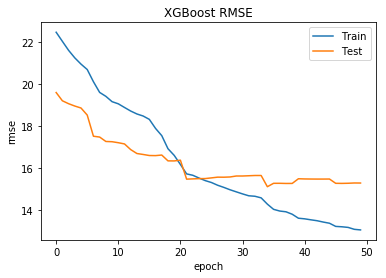

In [7]:
def plot_xgboost_rmse(model):
    "Plot xgboost rmse learning from model"
    fig, ax = plt.subplots()

    results = model.evals_result()
    ax.plot(results['validation_0']['rmse'], label='Train')
    ax.plot(results['validation_1']['rmse'], label='Test')
    ax.legend()
    plt.ylabel('rmse')
    plt.xlabel('epoch')
    plt.title('XGBoost RMSE')
    
plot_xgboost_rmse(xg_reg_cv)

Is it any different if we avoid the crossfold training?

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

xg_reg_single = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 1, n_estimators = 50, num_boost_round=200)

In [9]:
xg_reg_single.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_test, y_test)],
                  eval_metric='rmse')

[14:06:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:21.4555	validation_1-rmse:24.3158
[1]	validation_0-rmse:21.0724	validation_1-rmse:23.9734
[2]	validation_0-rmse:20.7058	validation_1-rmse:23.7663
[3]	validation_0-rmse:20.3989	validation_1-rmse:23.6209
[4]	validation_0-rmse:20.1536	validation_1-rmse:23.42
[5]	validation_0-rmse:19.9031	validation_1-rmse:23.2077
[6]	validation_0-rmse:19.1357	validation_1-rmse:22.3338
[7]	validation_0-rmse:18.695	validation_1-rmse:21.9921
[8]	validation_0-rmse:18.511	validation_1-rmse:21.8532
[9]	validation_0-rmse:18.3492	validation_1-rmse:21.6098
[10]	validation_0-rmse:18.2657	validation_1-rmse:21.5564
[11]	validation_0-rmse:18.1287	validation_1-rmse:21.447
[12]	validation_0-rmse:17.9859	validation_1-rmse:21.2933
[13]	validation_0-rmse:17.8692	validation_1-rmse:21.1651
[14]	validation_0-rmse:17.7809	validation_1-rmse:21.0692
[15]	validation_0-rmse:17.6046	va

XGBRegressor(alpha=1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.3, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, num_boost_round=200, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1)

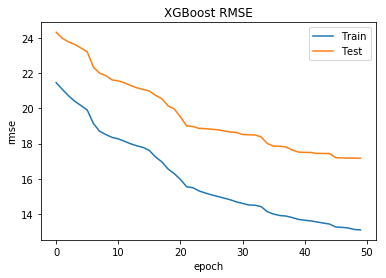

In [10]:
plot_xgboost_rmse(xg_reg_single)

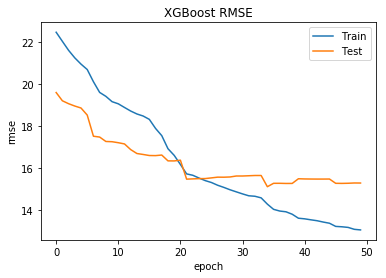

In [11]:
plot_xgboost_rmse(xg_reg_cv)

Yup, seems worse.

Now let's try making predictions on the data from the last 6 months of 2019.

In [12]:
X_validation, y_validation = validation_data.iloc[:,1:], validation_data.iloc[:,0]
y_preds = xg_reg_cv.predict(X_validation)

In [13]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_validation, y_preds))
print("RMSE: %f" % rmse)

RMSE: 4.861969


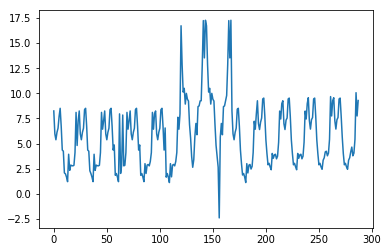

In [14]:
plt.plot(y_preds)

/home/aardvark/dev/loostmap/venv/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


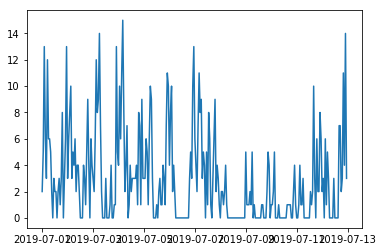

In [15]:
plt.plot(y_validation)

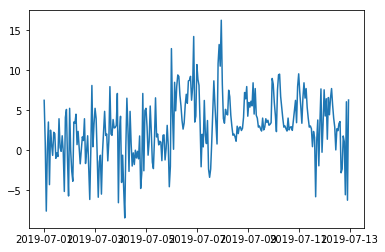

In [16]:
plt.plot(y_preds - y_validation)

Let's take a look at importance:

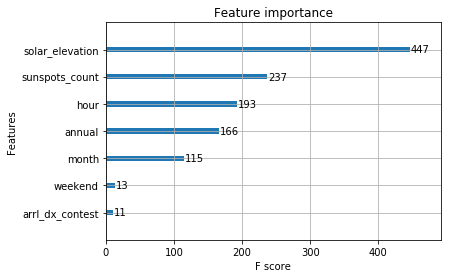

In [17]:
xgb.plot_importance(xg_reg_single)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

Some things to note:

- We're definitely seeing improvement here!

- But ohh, that graph of predictions looks a lot like the same pattern over and over again. :-(

- We're not using `logcosh` for training as we did with the Keras neural network in notebook 10, as XGBoost doesn't support that.

- We also didn't use rmse for plotting loss in notebook 10.

- The feature importance graph is interesting.

In [22]:
import pickle

pickle.dump(xg_reg_cv, open("../models/notebook_11-hpb-xgboost_cv.dat", "wb"))

# TODO

- **DONE:** Figure out how to get the performance of the cross-val model and still be able to save the model.  [This article from Machine Learning Mastery](https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/) may help.
- **DONE:** Try predicting with last 6 months of 2019, and plot results.
- Save the model and get it into Alorithmia.
